<a href="https://colab.research.google.com/github/Neeraja4716/AI-PE/blob/master/Satimental_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re

In [2]:
data = pd.read_csv('/content/Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [3]:
data = data[data.sentiment != "Neutral"]
data['text'] = data['text'].apply(lambda x: x.lower())
data['text'] = data['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['text'].values)
X = tokenizer.texts_to_sequences(data['text'].values)
X = pad_sequences(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


4472
16986


In [4]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 28, 128)           256000    
                                                                 
 spatial_dropout1d (SpatialD  (None, 28, 128)          0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 196)               254800    
                                                                 
 dense (Dense)               (None, 2)                 394       
                                                                 
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [5]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(7188, 28) (7188, 2)
(3541, 28) (3541, 2)


In [6]:
batch_size = 32
model.fit(X_train, Y_train, epochs = 7, batch_size=batch_size, verbose = 2)

Epoch 1/7
225/225 - 35s - loss: 0.4290 - accuracy: 0.8169 - 35s/epoch - 154ms/step
Epoch 2/7
225/225 - 31s - loss: 0.3190 - accuracy: 0.8657 - 31s/epoch - 139ms/step
Epoch 3/7
225/225 - 31s - loss: 0.2783 - accuracy: 0.8848 - 31s/epoch - 140ms/step
Epoch 4/7
225/225 - 31s - loss: 0.2479 - accuracy: 0.9003 - 31s/epoch - 139ms/step
Epoch 5/7
225/225 - 31s - loss: 0.2206 - accuracy: 0.9105 - 31s/epoch - 139ms/step
Epoch 6/7
225/225 - 31s - loss: 0.1953 - accuracy: 0.9211 - 31s/epoch - 139ms/step
Epoch 7/7
225/225 - 31s - loss: 0.1803 - accuracy: 0.9253 - 31s/epoch - 139ms/step


In [7]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

64/64 - 2s - loss: 0.4375 - accuracy: 0.8442 - 2s/epoch - 24ms/step
score: 0.44
acc: 0.84


In [8]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_validate)):
    
    result = model.predict(X_validate[x].reshape(1,X_test.shape[1]),batch_size=1,verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(Y_validate[x]):
        if np.argmax(Y_validate[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(Y_validate[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1



print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")


1/1 - 0s - 290ms/epoch - 290ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 25ms/epoch - 25ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 22ms/epoch - 22ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 23ms/epoch - 23ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 24ms/epoch - 24ms/step
1/1 - 0s - 29ms/epoch - 29ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 28ms/epoch - 28ms/step
1/1 - 0s - 27ms/epoch - 27ms/step
1/1 - 0s - 26ms/epoch - 26ms/step
1/1 - 0s - 2

In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split # function for splitting data to train and test sets

import nltk
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier

from wordcloud import WordCloud,STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output

In [10]:
data = pd.read_csv('/content/Sentiment.csv')
# Keeping only the neccessary columns
data = data[['text','sentiment']]

In [11]:
# Splitting the dataset into train and test set
train, test = train_test_split(data,test_size = 0.1)
# Removing neutral sentiments
train = train[train.sentiment != "Neutral"]

Positive words


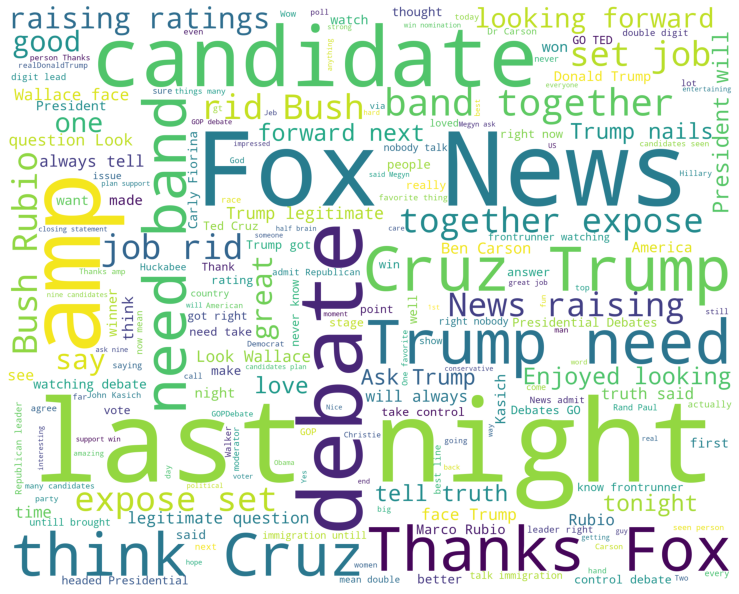

Negative words


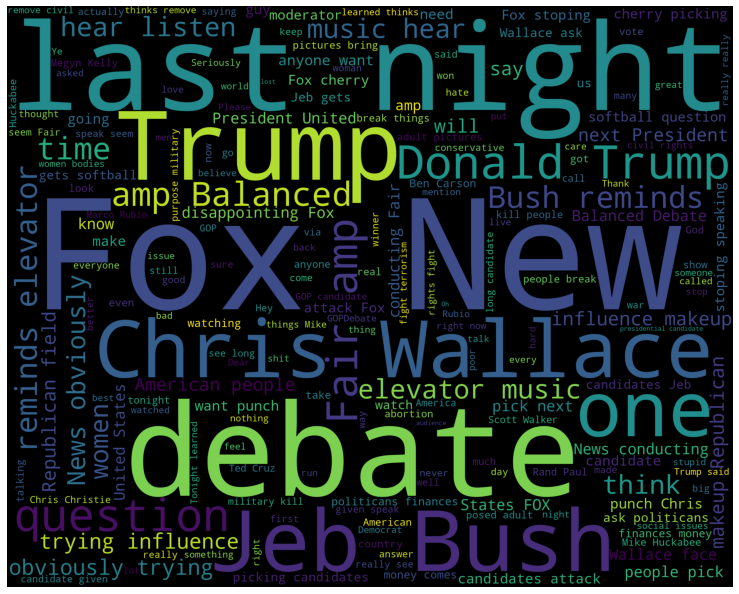

In [12]:
train_pos = train[ train['sentiment'] == 'Positive']
train_pos = train_pos['text']
train_neg = train[ train['sentiment'] == 'Negative']
train_neg = train_neg['text']

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()
    
print("Positive words")
wordcloud_draw(train_pos,'white')
print("Negative words")
wordcloud_draw(train_neg)

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
               tweets = []
stopwords_set = set(stopwords.words("english"))

for index, row in train.iterrows():
    words_filtered = [e.lower() for e in row.text.split() if len(e) >= 3]
    words_cleaned = [word for word in words_filtered
        if 'http' not in word
        and not word.startswith('@')
        and not word.startswith('#')
        and word != 'RT']
    words_without_stopwords = [word for word in words_cleaned if not word in stopwords_set]
    tweets.append((words_cleaned,row.sentiment))

test_pos = test[ test['sentiment'] == 'Positive']
test_pos = test_pos['text']
test_neg = test[ test['sentiment'] == 'Negative']
test_neg = test_neg['text']

In [17]:
# Extracting word features
def get_words_in_tweets(tweets):
    all = []
    for (words, sentiment) in tweets:
        all.extend(words)
    return all

def get_word_features(wordlist):
    wordlist = nltk.FreqDist(wordlist)
    features = wordlist.keys()
    return features
w_features = get_word_features(get_words_in_tweets(tweets))

def extract_features(document):
    document_words = set(document)
    features = {}
    for word in w_features:
        features['containts(%s)' % word] = (word in document_words)
    return features

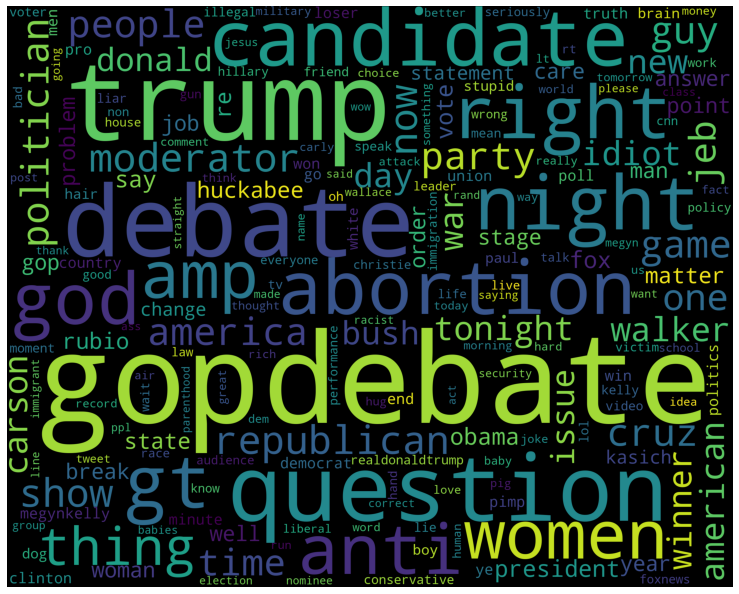

In [18]:
wordcloud_draw(w_features)

In [19]:
training_set = nltk.classify.apply_features(extract_features,tweets)
classifier = nltk.NaiveBayesClassifier.train(training_set)

In [20]:
neg_cnt = 0
pos_cnt = 0
for obj in test_neg: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Negative'): 
        neg_cnt = neg_cnt + 1
for obj in test_pos: 
    res =  classifier.classify(extract_features(obj.split()))
    if(res == 'Positive'): 
        pos_cnt = pos_cnt + 1
        
print('[Negative]: %s/%s '  % (len(test_neg),neg_cnt))        
print('[Positive]: %s/%s '  % (len(test_pos),pos_cnt))    

[Negative]: 866/825 
[Positive]: 213/76 
